In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

from collections import Counter
a4_dims = (11.69,8.27)
from scipy.stats import poisson, zipf
from scipy.special import comb

In [2]:
def edge_sample(G, p, seed=None):
    edges = G.edges()
    sampled=[]
    if seed is not None:
        random.Seed(seed)
    for e in edges:
        r = random.random()
        if r < p:
            sampled.append(e)
    H = nx.Graph()
    H.add_edges_from(sampled)
    return H

def count2freq(arr):
    counter = Counter(arr)
    tot = sum(counter.values())
    for k in counter:
        counter[k]/=tot
    return counter

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum

In [3]:
def setup_axes(x,y,xscale="linear",yscale="linear"):
    fig, ax = plt.subplots(figsize = a4_dims)
    ax.set_xlabel(x,fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel(y, fontsize=20)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    return fig, ax

In [4]:
def triangles(n1, n2, G):
    if not G.has_edge(n1,n2):
        return 0
    else:
        return len(list(nx.common_neighbors(G,n1,n2)))
    
def edge_triangle_count(G):
    tc = []
    for i in G.nodes():
        for j in G.neighbors(i):
            if i>j:
                continue
            tc.append(triangles(i,j,G))
    return tc

def edge_triangle_dict(G):
    tc={}
    for u,v in G.edges():
        tc[(min(u,v),max(u,v))]=triangles(u,v,G)
    return tc

def common_neighbours(n1, n2, G):
    n1neigh = set(G.neighbors(n1))
    n2neigh = set(G.neighbors(n2))
    return len(n1neigh.intersection(n2neigh)), G.has_edge(n1,n2)

def local_wedge_count(G):
    nodes = sorted(G.nodes())
    ec = []
    for i in range(len(nodes)):
        for j in range(i):
            cn = common_neighbours(nodes[i],nodes[j],G)
            if cn[0]!=0:
                ec.append(cn[0])
    return ec

def wedge_count(G):
    return 0.5*sum([d*(d-1) for n,d in G.degree()])

def scaleup_triangle_count(tri_array, p):
    return [round(1.0/p**3*ct) for ct in tri_array]

def scaleup_wedge(H,p):
    return 1.0/p**2*wedge_count(H)

def scaleup_local_wedge(H,p):
    return 1.0/p**2*np.array(H)

def scaleup_clustering_coeff(H,p):
    wc = 1.0/p**2*wedge_count(H)
    t_array = scaleup_triangle_count(edge_triangle_count(H),p)
    tc = sum(t_array)
    return t_array/wc

def tot_tri_estimate(H,p):
    tri_array = edge_triangle_count(H)/p**3
    return sum(tri_array)

def triangle_likelihood(t,tc,p):
    return comb(t,tc)*np.power((1.0-p*p),t)

def triangle_likelihood_normalised(t,tc,p):
    return math.comb(t,tc)*math.pow(p,2.0*tc)*math.pow(1.0-p*p,t-tc)

In [5]:
def get_tri_MSE_observed(G_tri,H,p,seed):
    m = len(H.edges())
    
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - len(H.edges())
    removed_edges = len(G.edges()) - len(H.edges())
    
    tl_sampled = edge_triangle_dict(H)
    tl_sampled_prop = count2freq(list(tl_sampled.values())+[0 for _ in range(missing_edges)])
    T_sampled = sum(tl_sampled.values())/3.0
    
    # simple p3 estimate
    T_estimated = T_sampled/p**3
    T_real = sum(G_tri.values())/3
    
    T_lambda = T_estimated*3.0/(len(H.edges())+missing_edges)
    wedge_lambda = 2*wedge_count(H)/(len(H.edges())+missing_edges)
    
    maxT=0
    while poisson.cdf(maxT,T_lambda)<0.9999:
        maxT+=1
        
#    maxT = max(G_tri.values())
    
    tl_prop = count2freq(G_tri.values())
    assert abs(sum(tl_prop.values()) - 1.0) < 0.0001, print("oh no")
    
    prob_caches={}
    Gp_tri={}
    Gp_tri_crude={}
    for u,v in H.edges():
        el = tl_sampled[(min(u,v),max(u,v))]
        den = tl_sampled_prop[el]
        num = 0.0
        for t in range(el,maxT+1):
            if (t,el) not in prob_caches:
                prob_caches[(t,el)]= triangle_likelihood_normalised(t,el,p) * poisson.pmf(t,T_lambda)
#                prob_caches[(t,el)]= triangle_likelihood_normalised(t,el,p) * tl_prop[t]
            fact = prob_caches[(t,el)]
            num+=t*fact
        Gp_tri[(min(u,v),max(u,v))]=num/den
        Gp_tri_crude[(min(u,v),max(u,v))]=el/p**3
        
    num=0.0
    el = 0
    den=tl_sampled_prop[el]
    for t in range(el,maxT+1):
        fact = triangle_likelihood_normalised(t,el,p) * poisson.pmf(t,T_lambda)
#        fact = triangle_likelihood_normalised(t,el,p) * tl_prop[t]
        num+=t*fact
    missing_triangles=removed_edges*(num/den)
    
    crude_mse = 1/m * sum([(Gp_tri_crude[x]-G_tri[x])**2 for x in Gp_tri_crude])
    post_mse = 1/m * sum([(Gp_tri[x]-G_tri[x])**2 for x in Gp_tri])
    post_T = (sum(Gp_tri.values())+missing_triangles)/3
    
    return crude_mse, post_mse, abs(T_estimated - T_real), abs(post_T - T_real)

In [114]:
def get_tri_MSE_LOTP(G_tri,H,p,seed):
    m = len(H.edges())
    
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - len(H.edges())
    removed_edges = len(G.edges()) - len(H.edges())
    
    tl_sampled = edge_triangle_dict(H)
    tl_sampled_prop = count2freq(list(tl_sampled.values())+[0 for _ in range(missing_edges)])
    T_sampled = sum(tl_sampled.values())/3.0
    
    # simple p3 estimate
    T_estimated = T_sampled/p**3
    T_real = sum(G_tri.values())/3
    
    T_lambda = T_estimated*3.0/(len(H.edges())+missing_edges)
    
#     # Comment out appropriately
    
#     maxT=0
#     poisson_vals = []
#     while poisson.cdf(maxT,T_lambda)<0.9999:
#         poisson_vals.append(poisson.pmf(maxT,T_lambda))
#         maxT+=1
#     poisson_vals.append(poisson.pmf(maxT,T_lambda))
    
#     maxT = max(G_tri.values())
    
    tl_prop = count2freq(G_tri.values())
    
    Gp_tri={}
    Gp_tri_crude={}
    new_tri={}
    for tp in tl_sampled_prop:
        num = poisson(T_lambda).expect(lambda t: t*triangle_likelihood(t,tp,p), lb=tp, maxcount=100)
        den = poisson(T_lambda).expect(lambda t: triangle_likelihood(t,tp,p), lb=tp, maxcount=100)
        new_tri[tp]=num/den
        
    for u,v in H.edges():
        tp = tl_sampled[(min(u,v),max(u,v))]
        Gp_tri[(min(u,v),max(u,v))] = new_tri[tp]
        Gp_tri_crude[(min(u,v),max(u,v))]=tp/p**2
        
    
#     prob_caches={}
#     Gp_tri={}
#     Gp_tri_crude={}
#     for u,v in H.edges():
#         el = tl_sampled[(min(u,v),max(u,v))]
#         den = 0.0
#         num = 0.0
        
#         num = poisson(T_lambda).expect(lambda t: t * likelihood(t,el,p), lb=el, maxcount=100)
#         den = poisson(T_lambda).expect(lambda t: likelihood(t,el,p), lb=el, maxcount=100)
        
#         for t in range(el,maxT+1):
#             if (t,el) not in prob_caches:
#                 prob_caches[(t,el)]= triangle_likelihood(t,el,p) * poisson_vals[t]
#                 #prob_caches[(t,el)]= triangle_likelihood(t,el,p) * tl_prop[t]
#             fact = prob_caches[(t,el)]
#             num+=t*fact
#             den+=fact
#         if den!=0.0:
#             Gp_tri[(min(u,v),max(u,v))]=num/den
#         else:
#             Gp_tri[(min(u,v),max(u,v))]=0.0
#         Gp_tri_crude[(min(u,v),max(u,v))]=el/p**2
        
#     num=0.0
#     el = 0
#     den=0.0
#     for t in range(el,maxT+1):
#         if (t,el) not in prob_caches:
#             #prob_caches[(t,el)] = triangle_likelihood(t,el,p) * poisson.pmf(t,T_lambda)
#             prob_caches[(t,el)]= triangle_likelihood(t,el,p) * tl_prop[t]
#         fact = prob_caches[(t,el)]
#         num+=t*fact
#         den+=fact
#     missing_triangles=missing_edges*(num/den)
    
    crude_mse = 1/m * sum([(Gp_tri_crude[x]-G_tri[x])**2 for x in Gp_tri_crude])
    post_mse = 1/m * sum([(Gp_tri[x]-G_tri[x])**2 for x in Gp_tri])
    post_T = sum(Gp_tri.values())/(3.0*p)
    
    return crude_mse, post_mse, abs(T_estimated - T_real), abs(post_T - T_real)

In [79]:
def getTriMSETrue(G_tri,H,p,seed):
    m = len(H.edges())
    
    edges_estimated = round(m/p)
    missing_edges = edges_estimated - len(H.edges())
    removed_edges = len(G.edges()) - len(H.edges())
    
    tl_sampled = edge_triangle_dict(H)
    tl_sampled_prop = count2freq(list(tl_sampled.values())+[0 for _ in range(removed_edges)])
    T_sampled = sum(tl_sampled.values())/3.0
    
    # simple p3 estimate
    T_estimated = T_sampled/p**3
    T_real = sum(G_tri.values())/3
    
    T_lambda = T_estimated*3.0/(len(H.edges())+removed_edges)
    wedge_lambda = 2*wedge_count(H)/(len(H.edges())+removed_edges)
    
    maxT=0
    while poisson.cdf(maxT,T_lambda)<0.9999:
        maxT+=1
        
    tl_prop=count2freq(G_tri.values())
    
    #tl_prop, tl_sample_prop = count2freq(tl_real), count2freq(tl_sampled)
    
    prob_caches={}
    Gp_tri={}
    Gp_tri_crude={}
    for u,v in H.edges():
        el = tl_sampled[(min(u,v),max(u,v))]
        den=0.0
        #den = tl_sampled_prop[el]
        num = 0.0
        for t in range(el,maxT+1):
            if (t,el) not in prob_caches:
                prob_caches[(t,el)]= triangle_likelihood(t,el,p) * tl_prop[t]
            fact = prob_caches[(t,el)]
            num+=t*fact
            den+=fact
        if den!=0.0:
            Gp_tri[(min(u,v),max(u,v))]=num/den
        else:
            Gp_tri[(min(u,v),max(u,v))]=0.0
        Gp_tri_crude[(min(u,v),max(u,v))]=el/p**3
        
    num=0.0
    el = 0
    den=0.0
    for t in range(el,maxT+1):
        if (t,el) not in prob_caches:
                prob_caches[(t,el)]= triangle_likelihood(t,el,p) * tl_prop[t]
        fact = prob_caches[(t,el)]
        num+=t*fact
        den+=fact
    missing_triangles=missing_edges*(num/den)
    
    crude_mse = 1/m * sum([(Gp_tri_crude[x]-G_tri[x])**2 for x in Gp_tri_crude])
    post_mse = 1/m * sum([(Gp_tri[x]-G_tri[x])**2 for x in Gp_tri])
    post_T = (sum(Gp_tri.values())+missing_triangles)/3
    
    return crude_mse, post_mse, abs(T_estimated - T_real), abs(post_T - T_real)

In [116]:
n, m, p, seed = 1000, 25000, 0.999, 101

G = nx.barabasi_albert_graph(n, 10,seed)
#G = nx.barabasi_albert_graph(n,10,seed)
H = edge_sample(G,p)

G_tri = edge_triangle_dict(G)
print(get_tri_MSE_LOTP(G_tri,H,p,seed))

(0.002623787024504178, 0.0026235351760928918, 5.568123862784887, 5.567997373835169)


# ER mean square error test

In [58]:
G = nx.read_gpickle("ER_FILES/REAL")
G_tri = edge_triangle_dict(G)
prange = np.linspace(0.1,0.9,9)
prange = [0.001]+list(prange)+[0.999]
print(prange)
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "ER_FILES/ER"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_tri_MSE_LOTP(G_tri,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse","mme_triangle_err","post_triangle_err"])
    df.to_csv("ER_FILES/tri-errors-pois-lotp-"+str(round(p,1))+".csv")

[0.001, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 0.999]


In [117]:
G = nx.read_gpickle("BA_FILES/REAL")
G_tri = edge_triangle_dict(G)
prange = [0.001]+list(prange)+[0.999]
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "BA_FILES/BA"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_tri_MSE_LOTP(G_tri,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse","mme_triangle_err","post_triangle_err"])
    df.to_csv("BA_FILES/tri-errors-pois-lotp-"+str(round(p,1))+".csv")

KeyboardInterrupt: 

In [119]:
G = nx.read_gpickle("FACEBOOK/REAL")
G_tri = edge_triangle_dict(G)
prange = np
prange = [0.001]+list(prange)+[0.999]
seed = 42

for p in prange:
    data = []
    for ex in range(50):
        fname = "FACEBOOK/FACEBOOK"+str(round(p,1))+"-"+str(ex)
        H = nx.read_gpickle(fname)
        data.append(get_tri_MSE_LOTP(G_tri,H,p,seed))
    df = pd.DataFrame(data,columns = ["naive_mse","post_mse","mme_triangle_err","post_triangle_err"])
    df.to_csv("FACEBOOK/tri-errors-pois-lotp-"+str(round(p,1))+".csv")

KeyboardInterrupt: 

In [113]:
def triangle_plot(folder,name):
    prange = np.linspace(0.1,0.9,9) 
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5), sharex=True)
    
    edge_means = np.zeros(9)
    edge_sds = np.zeros(9)
    
    tri_means = np.zeros(9)
    tri_sds = np.zeros(9)
    
    edge_means_post = np.zeros(9)
    edge_sds_post = np.zeros(9)
    
    tri_means_post = np.zeros(9)
    tri_sds_post = np.zeros(9)
    
    edge_means_true = np.zeros(9)
    edge_sds_true = np.zeros(9)
    
    tri_means_true = np.zeros(9)
    tri_sds_true = np.zeros(9)
    
    for i in range(9):
        p = prange[i]
        fname = folder+"/tri-errors-pois-observed-"+str(round(p,1))+".csv"
        fname2 = folder+"/tri-errors-true-observed-"+str(round(p,1))+".csv"
        df = pd.read_csv(fname)
        df2 = pd.read_csv(fname2)
        
        edge_means[i]=np.sqrt(df[["naive_mse"]].mean())
        edge_means_post[i]=np.sqrt(df[["post_mse"]].mean())
        edge_means_true[i]=np.sqrt(df2[["post_mse"]].mean())
        
        tri_means[i]=(df[["mme_triangle_err"]]**2).mean()
        tri_means_post[i]=(df[["post_triangle_err"]]**2).mean()
        tri_means_true[i]=(df2[["post_triangle_err"]]**2).mean()
        
        tri_sds[i] = np.sqrt((df[["mme_triangle_err"]]**2).std())
        tri_sds_post[i]= np.sqrt((df[["post_triangle_err"]]**2).std())
        tri_sds_true[i]= np.sqrt((df2[["post_triangle_err"]]**2).std())
        
        edge_sds[i] = df[["naive_mse"]].std()
        edge_sds_post[i] = df[["post_mse"]].std()
        edge_sds_true[i] = df2[["post_mse"]].std()
        
    print(tri_sds_post)
    ax[0].plot(prange,edge_means,label="MME error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means-0.5*edge_sds, edge_means+0.5*edge_sds,alpha=0.3)
    ax[0].plot(prange,edge_means_post,label = "Poisson prior error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means_post-edge_sds_post*0.5, edge_means_post+edge_sds_post*0.5,alpha=0.3)
    ax[0].plot(prange,edge_means_true,label = "True prior error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means_true-edge_sds_true*0.5, edge_means_true+edge_sds_true*0.5,alpha=0.3)
    
    ax[1].plot(prange,np.sqrt(tri_means),label="MME error",linewidth=3,marker='x')
    ax[1].plot(prange,np.sqrt(tri_means_post),label="Poisson prior error",linewidth=3,marker='x')
    ax[1].plot(prange,np.sqrt(tri_means_true),label="True prior error",linewidth=3,marker='x')
    ax[1].fill_between(prange,np.sqrt(tri_means)-0.5*tri_sds,np.sqrt(tri_means)+0.5*tri_sds,alpha=0.3)
    ax[1].fill_between(prange,np.sqrt(tri_means_post)-0.5*tri_sds_post,np.sqrt(tri_means_post)+0.5*tri_sds_post,alpha=0.3)
    ax[1].fill_between(prange,np.sqrt(tri_means_true)-0.5*tri_sds_post,np.sqrt(tri_means_true)+0.5*tri_sds_true,alpha=0.3)
    
    ax[0].legend(loc="upper right",fontsize=16)
    ax[1].legend(loc="upper right",fontsize=16)
    
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Edge triangle count RMSE',fontsize=16)
    ax[0].set_xlabel('Sampling probability $p$',fontsize=16)
    ax[1].set_ylabel('Total triangle count RMSE',fontsize=16)
    ax[1].set_xlabel('Sampling probability $p$',fontsize=16)
    ax[1].set_yscale('log')
    
    plt.savefig(folder+"/"+name+"ErrorObserved.pdf")
    plt.show()

In [16]:
def triangle_plot_LOTP(folder,name):
    prange = np.linspace(0.0,1.0,11) 
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5), sharex=True)
    
    edge_means = np.zeros(11)
    edge_sds = np.zeros(11)
    
    tri_means = np.zeros(11)
    tri_sds = np.zeros(11)
    
    edge_means_post = np.zeros(11)
    edge_sds_post = np.zeros(11)
    
    tri_means_post = np.zeros(11)
    tri_sds_post = np.zeros(11)
    
    edge_means_true = np.zeros(11)
    edge_sds_true = np.zeros(11)
    
    tri_means_true = np.zeros(11)
    tri_sds_true = np.zeros(11)
    
    for i in range(11):
        p = prange[i]
        fname = folder+"/tri-errors-pois-lotp-"+str(round(p,1))+".csv"
        fname2 = folder+"/tri-errors-true-lotp-"+str(round(p,1))+".csv"
        df = pd.read_csv(fname)
        df2 = pd.read_csv(fname2)
        
        edge_means[i]=np.sqrt(df[["naive_mse"]].mean())
        edge_means_post[i]=np.sqrt(df[["post_mse"]].mean())
        edge_means_true[i]=np.sqrt(df2[["post_mse"]].mean())
        
        tri_means[i]=(df[["mme_triangle_err"]]**2).mean()
        tri_means_post[i]=(df[["post_triangle_err"]]**2).mean()
        tri_means_true[i]=(df2[["post_triangle_err"]]**2).mean()
        
        tri_sds[i] = np.sqrt((df[["mme_triangle_err"]]**2).std())
        tri_sds_post[i]= np.sqrt((df[["post_triangle_err"]]**2).std())
        tri_sds_true[i]= np.sqrt((df2[["post_triangle_err"]]**2).std())
        
        edge_sds[i] = df[["naive_mse"]].std()
        edge_sds_post[i] = df[["post_mse"]].std()
        edge_sds_true[i] = df2[["post_mse"]].std()
        
    prange[0]=0.001
    prange[-1]=0.999
    ax[0].plot(prange,edge_means,label="MME error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means-0.5*edge_sds, edge_means+0.5*edge_sds,alpha=0.3)
    ax[0].plot(prange,edge_means_post,label = "Poisson prior error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means_post-edge_sds_post*0.5, edge_means_post+edge_sds_post*0.5,alpha=0.3)
    ax[0].plot(prange,edge_means_true,label = "True prior error",linewidth=3,marker='x')
    ax[0].fill_between(prange,edge_means_true-edge_sds_true*0.5, edge_means_true+edge_sds_true*0.5,alpha=0.3)
    
    ax[1].plot(prange,np.sqrt(tri_means),label="MME error",linewidth=3,marker='x')
    ax[1].plot(prange,np.sqrt(tri_means_post),label="Poisson prior error",linewidth=3,marker='x')
    ax[1].plot(prange,np.sqrt(tri_means_true),label="True prior error",linewidth=3,marker='x')
    ax[1].fill_between(prange,np.sqrt(tri_means)-0.5*tri_sds,np.sqrt(tri_means)+0.5*tri_sds,alpha=0.3)
    ax[1].fill_between(prange,np.sqrt(tri_means_post)-0.5*tri_sds_post,np.sqrt(tri_means_post)+0.5*tri_sds_post,alpha=0.3)
    ax[1].fill_between(prange,np.sqrt(tri_means_true)-0.5*tri_sds_post,np.sqrt(tri_means_true)+0.5*tri_sds_true,alpha=0.3)
    
    ax[0].legend(loc="upper right",fontsize=16)
    ax[1].legend(loc="upper right",fontsize=16)
    
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Edge triangle count RMSE',fontsize=16)
    ax[0].set_xlabel('Sampling probability $p$',fontsize=16)
    ax[1].set_ylabel('Total triangle count RMSE',fontsize=16)
    ax[1].set_xlabel('Sampling probability $p$',fontsize=16)
    ax[1].set_yscale('log')
    
    ax[0].tick_params(axis='x', labelsize= 16)
    ax[1].tick_params(axis='x', labelsize= 16)
    ax[0].tick_params(axis='y', labelsize= 16)
    ax[1].tick_params(axis='y', labelsize= 16)
    
    plt.savefig(folder+"/"+name+"ErrorLOTP.pdf")
    plt.tight_layout()
    plt.show()

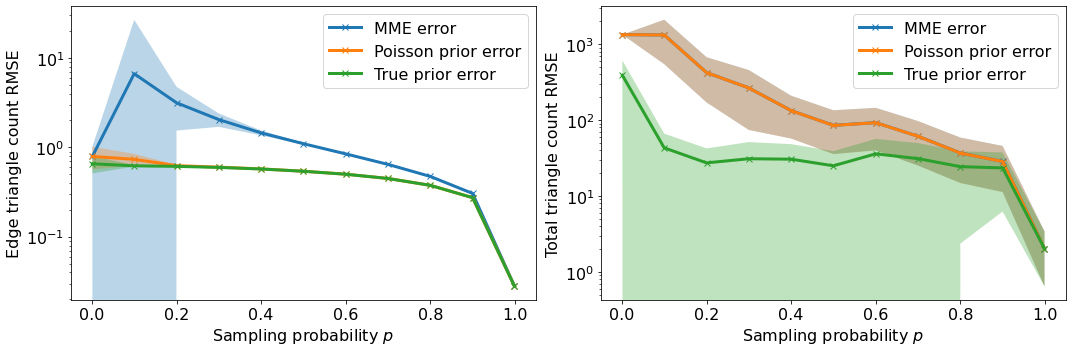

In [17]:
triangle_plot_LOTP("ER_FILES","ER")

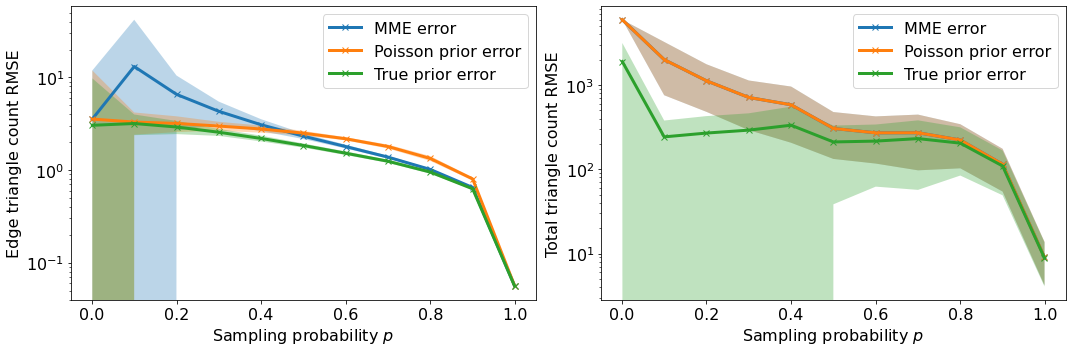

In [18]:
triangle_plot_LOTP("BA_FILES","BA")

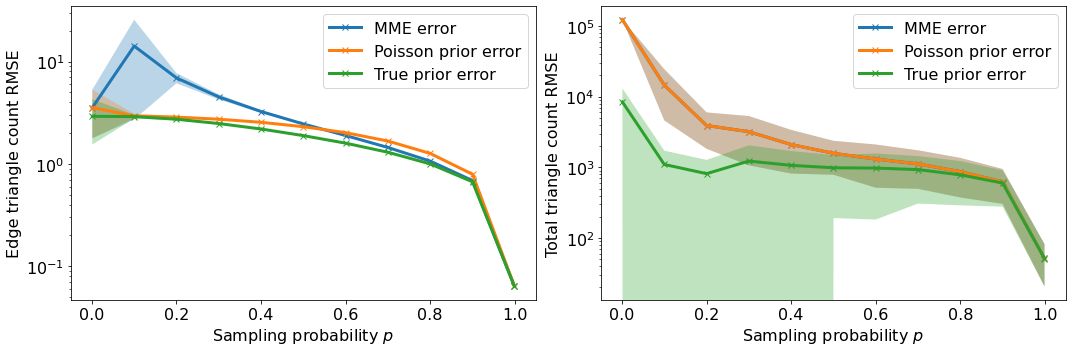

In [19]:
triangle_plot_LOTP("FACEBOOK","FACEBOOK")

In [91]:
n, m, p, seed = 1000, 10000, 0.7, 101

G = nx.gnm_random_graph(n, m,seed)
#G = nx.barabasi_albert_graph(n,10,seed)
H = edge_sample(G,p)

G_tri = edge_triangle_dict(G)
print(getTriMSETrue(G_tri,H,p,seed))

624.4084916106392
(0.9881660079486079, 0.2053737878824131, 4.807580174926898, 196.98859211833883)
